<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Merging-attributes-from-BioSample-using-word2vec" data-toc-modified-id="Merging-attributes-from-BioSample-using-word2vec-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Merging attributes from BioSample using word2vec</a></span><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Set-up</a></span><ul class="toc-item"><li><span><a href="#Import-needed-packages" data-toc-modified-id="Import-needed-packages-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Import needed packages</a></span></li><li><span><a href="#Helper-function-definitions" data-toc-modified-id="Helper-function-definitions-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Helper function definitions</a></span></li><li><span><a href="#Load-data-and-embedding-model" data-toc-modified-id="Load-data-and-embedding-model-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Load data and embedding model</a></span></li><li><span><a href="#Supp.-Figure1F-Define-attribute-groupings" data-toc-modified-id="Supp.-Figure1F-Define-attribute-groupings-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span><font color="red">Supp. Figure1F</font> Define attribute groupings</a></span></li></ul></li><li><span><a href="#Calculate-average-embedding-vectors" data-toc-modified-id="Calculate-average-embedding-vectors-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Calculate average embedding vectors</a></span><ul class="toc-item"><li><span><a href="#(Optional)-Cap-at-100-samples-per-study-to-avoid-study-bias-and-use-only-those-attributes-that-are-similar-to-defined-classes" data-toc-modified-id="(Optional)-Cap-at-100-samples-per-study-to-avoid-study-bias-and-use-only-those-attributes-that-are-similar-to-defined-classes-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>(Optional) Cap at 100 samples per study to avoid study bias and use only those attributes that are similar to defined classes</a></span></li><li><span><a href="#Build-dataframe-from-subset-or-total" data-toc-modified-id="Build-dataframe-from-subset-or-total-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Build dataframe from subset or total</a></span></li><li><span><a href="#Randomly-sample-100-of-each-attribute-that-occurs-greater-than-100-times" data-toc-modified-id="Randomly-sample-100-of-each-attribute-that-occurs-greater-than-100-times-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Randomly sample 100 of each attribute that occurs greater than 100 times</a></span></li><li><span><a href="#Get-average-embedding-vector-for-each-attribute" data-toc-modified-id="Get-average-embedding-vector-for-each-attribute-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Get average embedding vector for each attribute</a></span></li></ul></li><li><span><a href="#Merge-entities-with-high-cosine-similarity" data-toc-modified-id="Merge-entities-with-high-cosine-similarity-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Merge entities with high cosine similarity</a></span></li><li><span><a href="#Supp.-Table1-Determine-coverage-increase-with-merging" data-toc-modified-id="Supp.-Table1-Determine-coverage-increase-with-merging-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span><font color="red">Supp. Table1</font> Determine coverage increase with merging</a></span></li><li><span><a href="#Analyze-word-embedding-space" data-toc-modified-id="Analyze-word-embedding-space-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Analyze word embedding space</a></span><ul class="toc-item"><li><span><a href="#Figure3A:-PCA-of-class-based-terms" data-toc-modified-id="Figure3A:-PCA-of-class-based-terms-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span><font color="red">Figure3A:</font> PCA of class based terms</a></span></li><li><span><a href="#Figure3B:-Cosine-similarity-based-hierarchical-clustering-of-class-based-terms" data-toc-modified-id="Figure3B:-Cosine-similarity-based-hierarchical-clustering-of-class-based-terms-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span><font color="red">Figure3B:</font> Cosine similarity based hierarchical clustering of class based terms</a></span></li><li><span><a href="#Figure3C:-PCA-of-data-type-based-terms" data-toc-modified-id="Figure3C:-PCA-of-data-type-based-terms-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span><font color="red">Figure3C:</font> PCA of data type based terms</a></span></li><li><span><a href="#Figure3D:-Cosine-similarity-based-hierarchical-clustering-of-data-type-based-terms" data-toc-modified-id="Figure3D:-Cosine-similarity-based-hierarchical-clustering-of-data-type-based-terms-1.5.4"><span class="toc-item-num">1.5.4&nbsp;&nbsp;</span><font color="red">Figure3D:</font> Cosine similarity based hierarchical clustering of data type based terms</a></span></li></ul></li></ul></li></ul></div>

# Merging attributes from BioSample using word2vec
Adam Klie<br>
11/17/2019<br>
Script to create classes as output for neural net using similarities between attribute word embeddings

## Set-up

### Import needed packages

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial as sp
import spacy

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [2]:
from matplotlib import rcParams
import matplotlib as mpl

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 600 
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'

rcParams['axes.labelsize'] = 30
rcParams['ytick.labelsize'] = 24
rcParams['xtick.labelsize'] = 24

### Helper function definitions

In [3]:
def correlate_dataframes(df1, df2, metric = 'cosine' ):
    M = 1 - sp.distance.cdist(df1, df2, metric)
    return pd.DataFrame(data = M, index = df1.index, columns = df2.index)

### Load data and embedding model

In [4]:
# Load embedding model
nlp = spacy.load('../data/wikipedia-pubmed-and-PMC-w2v')

In [5]:
# Load attribute-value pairs
SRS_dir = "../data/allSRS_05_15_2018.pickle"
sra_dump_pickle_dir = "../data/sra_dump.pickle"
allSRS = pd.read_pickle(SRS_dir)
technical_meta_data_df = pd.read_pickle(sra_dump_pickle_dir)

### <font color=red>Supp. Figure1F</font> Define attribute groupings

In [6]:
orig_grouping = pd.Series({'SCIENTIFIC_NAME':'Species',
                           'genotype':'Genotype',
                           'disease':'Disease state',
                           'cell type':'Cell type/tissue',
                           'tissue':'Cell type/tissue',
                           'geo_loc_name':'Geographical Location',
                           'treatment':'Treatment and conditions'})

simple_grouping = pd.Series({'SCIENTIFIC_NAME':'Species',
                            'cell type':'Cell type',
                            'genotype':'Genotype',
                            'disease':'Condition/Disease',
                            'tissue':'Tissue'})

eleven_class_grouping = pd.Series({'SCIENTIFIC_NAME':'Species',
                                   'strain':'Strain',
                                   'cell type':'Cell type',
                                   'genotype':'Genotype',
                                   'disease':'Condition/Disease',
                                   'tissue':'Tissue',
                                   'sex':'Sex',
                                   'age':'Age',
                                   'molecular data type':'Data type',
                                   'platform':'Platform',
                                   'protocol':'Protocol'})

In [7]:
grouping = eleven_class_grouping

In [8]:
model_iter = "11_class"

In [9]:
pd.DataFrame(grouping).reset_index().to_csv('../doc/figures/Supplementary/Supp_Figure1F.csv', 
                                            index=False)

## Calculate average embedding vectors

### (Optional) Cap at 100 samples per study to avoid study bias and use only those attributes that are similar to defined classes

In [15]:
max_sample_per_study_n = 100
capped_samples = technical_meta_data_df.groupby('Study').head(n = max_sample_per_study_n)['Sample']
print("Number of samples left after capping: %d" % (len(capped_samples)))

Number of samples left after capping: 2348023


In [16]:
capped_m = allSRS.index.get_level_values(0).isin(capped_samples.values)

In [17]:
subset_SRS = allSRS[capped_m]

### Build dataframe from subset or total

In [11]:
#SRS_df = pd.DataFrame(subset_SRS).reset_index()
SRS_df = pd.DataFrame(allSRS).reset_index()
SRS_df.columns = ['srs', 'attribute', 'value']

### Randomly sample 100 of each attribute that occurs greater than 100 times

In [12]:
# Take only attributes with more than 100 samples to compare
attribute_counts = SRS_df['attribute'].value_counts()
recurr_attrib = attribute_counts.index[attribute_counts > 100]
recurring_df = SRS_df[SRS_df.attribute.isin(recurr_attrib)]

In [13]:
print("There are %d recurring attributes (greater than 100 samples)" % len(recurr_attrib))

There are 6823 recurring attributes (greater than 100 samples)


In [14]:
# Randomly sample 100 per entities for generating entity vector
shuffled_df = recurring_df.sample(recurring_df.shape[0])
subset_df = shuffled_df.groupby('attribute').head(n = 100)
del recurring_df, shuffled_df

### Get average embedding vector for each attribute

In [15]:
# Get vector representation for all attribute-value pairs randomly selected
docs = nlp.pipe(subset_df['value'].tolist())
vectors = [doc.vector for doc in docs]
doc_vector_df = pd.DataFrame(vectors, index = subset_df.set_index(['srs','attribute','value']).index).astype(float)

In [16]:
# Take average of each attribute and correlate them by cosine similarity
attribute_means = doc_vector_df.groupby('attribute').mean()
embedding_df = attribute_means[attribute_means.sum(axis=1).abs()>0]
corr_df = correlate_dataframes(embedding_df, embedding_df)

Text(0.5,1,'Distribution of cosine similarities of attributes')

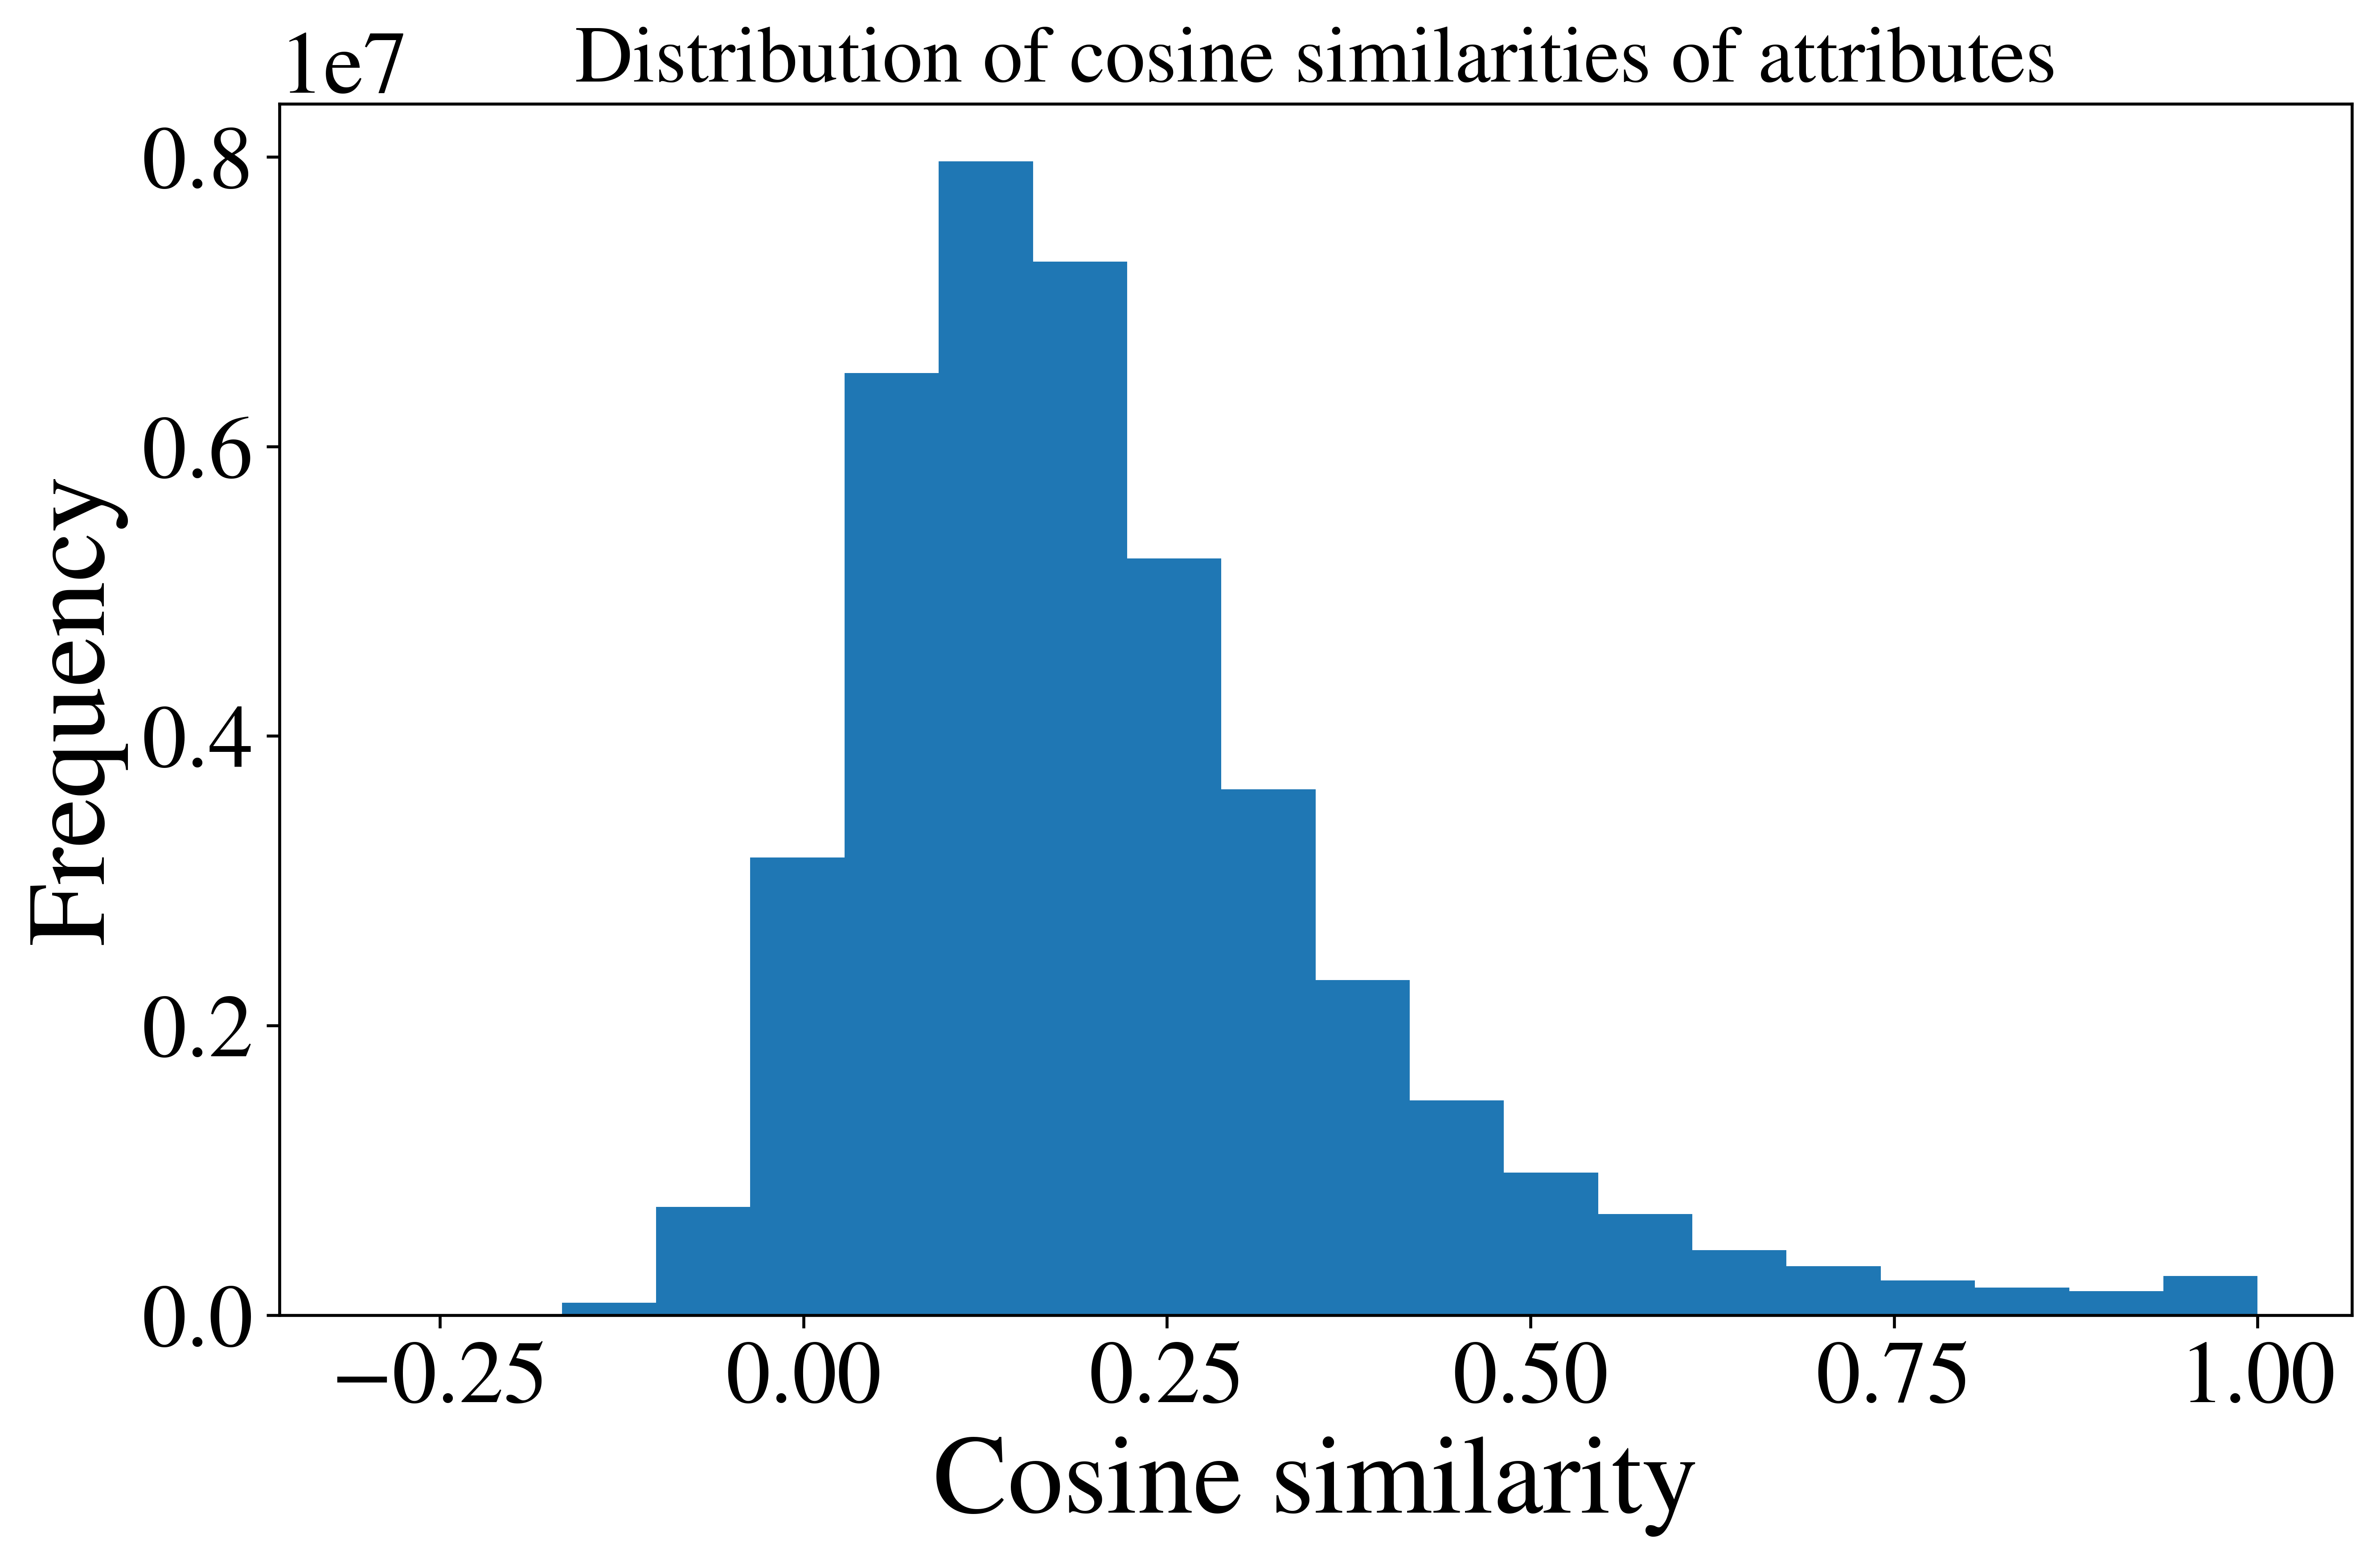

In [17]:
plt.hist(corr_df.unstack().dropna(), bins = 20)
plt.xlabel("Cosine similarity")
plt.ylabel('Frequency')
plt.title('Distribution of cosine similarities of attributes')

## Merge entities with high cosine similarity

In [18]:
# Choose higher categories that will encompass merged attributes
similarity_threshold = 0.8
selected_seeds = grouping.index

In [19]:
# Find all attributes closest to the seed attributes by threshold
dataframe_list = []
for attribute in selected_seeds:
    if attribute == 'age':
        tmp_series = corr_df[attribute][corr_df[attribute].index.isin(['age', 'AGE', 'Age'])]
        tmp_df = tmp_series.sort_values(ascending = False).to_frame().reset_index()
    else:
        tmp_series = corr_df[attribute].sort_values(ascending = False)
        tmp_df = tmp_series[tmp_series>= similarity_threshold].to_frame().reset_index()
    tmp_df.columns = ['attribute','similarity']
    dataframe_list.append(tmp_df)

In [20]:
# Create a dataframe of entities that are similar
merged_df = pd.concat(dataframe_list, keys = selected_seeds, axis = 0)
merged_df.index.names=['GroupName','I']
merged_reset_df = merged_df.reset_index()
similar_df = merged_reset_df[merged_reset_df['similarity'] >= similarity_threshold]
similar_df['GroupName'] = grouping[similar_df['GroupName']].values

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
display(similar_df)

,GroupName,I,attribute,similarity,value count
0,Species,0,SCIENTIFIC_NAME,1.000000,2773124
1,Species,1,Organism,0.916653,3856
2,Species,2,host scientific name,0.910885,35597
3,Species,3,organism,0.903050,54635
4,Species,4,host_scientific_name,0.885668,19935
5,Species,5,host,0.883545,461663
6,Species,6,nat-host,0.859355,1542
7,Species,7,specific host,0.853367,16481
8,Species,8,host organism,0.850686,413
9,Species,9,host species,0.830982,119


In [21]:
similar_df.to_csv('../results/embedding/{model}/entity_merging.csv'.format(model = model_iter))

## <font color=red>Supp. Table1</font> Determine coverage increase with merging

In [22]:
similar_df['value count'] = SRS_df['attribute'].value_counts()[similar_df['attribute'].values].values

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
counts_df = similar_df[similar_df['attribute'].isin(['age', 'cell type', 'disease', 'molecular data type',
                                        'genotype', 'platform', 'protocol', 'sex', 'SCIENTIFIC_NAME',
                                        'strain', 'tissue'])].sort_values('GroupName').drop('I', axis = 1)
counts_df['merged count'] = similar_df.groupby('GroupName').sum()['value count'].values
counts_df['factor of increase'] = counts_df['merged count']/counts_df['value count']

In [24]:
display(counts_df)

,GroupName,attribute,similarity,value count,merged count,factor of increase
80,Age,age,1.0,363161,370206,1.019399
33,Cell type,cell type,1.0,150652,660709,4.385664
54,Condition/Disease,disease,1.0,36349,47714,1.312663
83,Data type,molecular data type,1.0,544515,544515,1.000000
45,Genotype,genotype,1.0,117332,154012,1.312617
84,Platform,platform,1.0,3476,147827,42.527906
103,Protocol,protocol,1.0,5851,9028,1.542984
65,Sex,sex,1.0,643290,807086,1.254622
0,Species,SCIENTIFIC_NAME,1.0,2773124,3412251,1.230472
12,Strain,strain,1.0,598496,834505,1.394337


In [27]:
counts_df.to_csv('../results/embedding/{model}/entity_coverage.csv'.format(model=model_iter))
counts_df.to_csv('../doc/figures/Supplementary/Supp_Table1.csv'.format(model=model_iter))

## Analyze word embedding space

In [40]:
from sklearn import manifold, decomposition
import seaborn as sns

In [41]:
keys = nlp.vocab.vectors.keys()

In [42]:
word_vec_df = pd.DataFrame(nlp.vocab.vectors.data, index = keys)

In [43]:
word_vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
2667587279770775948,0.001701,0.000166,0.001748,-0.000733,0.001669,0.000776,0.001303,-0.000944,-0.001797,-0.000134,...,0.001715,0.001459,0.002345,0.001057,0.000979,-0.001693,0.000151,0.001749,0.000048,-0.001742
7425985699627899538,0.155801,-0.071087,0.055198,-0.141998,0.000532,0.040514,-0.157303,0.035504,0.091874,0.032364,...,0.201029,0.223507,0.013706,0.171383,0.074172,-0.180557,0.085533,-0.044299,0.057632,0.006359
2593208677638477497,-0.059316,0.102907,0.002158,0.084926,-0.023946,0.105284,0.024068,0.131582,0.079721,0.118374,...,0.183382,0.097754,0.077573,0.108788,0.059441,-0.013179,0.149007,-0.026105,-0.038689,-0.079721
12646065887601541794,-0.010395,0.120041,-0.074264,-0.054721,-0.095818,0.049936,-0.128741,-0.012185,0.225156,0.042923,...,0.279434,0.090539,0.133916,0.204425,-0.072498,0.028723,-0.042401,-0.190231,-0.133390,0.194939
886050111519832510,0.077941,-0.005107,0.064805,-0.060963,-0.083622,-0.024057,-0.194617,0.038781,0.149339,-0.032660,...,0.150951,0.132817,-0.138992,0.196112,0.136153,-0.049858,0.157857,-0.036012,0.137212,-0.085172


In [44]:
keyToString={}
keys = nlp.vocab.vectors.keys()
for key in keys:
    if key in nlp.vocab.strings: 
        keyToString[key] = nlp.vocab.strings[key]

In [45]:
keyToStringS = pd.Series(keyToString)

In [46]:
strings = keyToStringS[nlp.vocab.vectors.keys()].values

/cellar/users/aklie/miniconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [47]:
word_vec_df.index = strings

### <font color=red>Figure3A:</font> PCA of class based terms

In [69]:
classes = word_vec_df.loc[['male', 'female', 'hermaphrodite', 
                           'atherosclerosis', 'cancer', "Alzheimer's",
                           'Microarray', 'RNA-seq', 'ChIP-seq',
                           'weeks', 'years', 'hours']]

In [70]:
dimensionReduction = decomposition.PCA(n_components = 2)
M = dimensionReduction.fit_transform(classes)

In [71]:
tmpDf = pd.DataFrame(data=M,index=classes.index)

In [72]:
var_exp = dimensionReduction.explained_variance_ratio_
PC_1 = var_exp[0]*100
PC_2 = var_exp[1]*100

In [73]:
fig,ax=plt.subplots(figsize=(6,6))
tmpDf.plot(x=0,y=1,kind='scatter',ax=ax,s=14)
for name,row in tmpDf.iterrows():
    ax.annotate(xy=(row[0],row[1]),s=name, fontsize=16)
ax.set_xlim(right=3.0)
ax.set_xlabel('PC1 (%.2f%%)' % PC_1)
ax.set_ylabel('PC2 (%.2f%%)' % PC_2)
plt.savefig('../doc/figures/Figure3/Figure3A.eps', dpi=600, bbox_inches="tight")
plt.savefig('../doc/figures/Figure3/Figure3A.png', dpi=600, bbox_inches="tight")
plt.close();

### <font color=red>Figure3B:</font> Cosine similarity based hierarchical clustering of class based terms

In [74]:
sns.clustermap(data=classes.T.corr(), metric='cosine', z_score=True)
plt.savefig('../doc/figures/Figure3/Figure3B.eps', dpi=600, bbox_inches="tight")
plt.savefig('../doc/figures/Figure3/Figure3B.png', dpi=600, bbox_inches="tight")
plt.close();

### <font color=red>Figure3C:</font> PCA of data type based terms

In [5]:
types = word_vec_df.loc[['DNase-seq', 'ChIP-seq', 'immunoprecipitation-sequencing', 
                         'mRNA-seq', 'RNA-sequencing', "RNA-seq",
                         'bisulfite-sequencing', 'Bis-seq', 'Methyl-seq', 'bisulfite-seq']]

NameError: name 'word_vec_df' is not defined

In [ ]:
dimensionReduction = decomposition.PCA(n_components = 2)
M = dimensionReduction.fit_transform(types)

In [ ]:
tmpDf = pd.DataFrame(data=M,index=types.index)

In [ ]:
var_exp = dimensionReduction.explained_variance_ratio_
PC_1 = var_exp[0]*100
PC_2 = var_exp[1]*100

In [ ]:
fig,ax=plt.subplots(figsize=(6,6))
tmpDf.plot(x=0,y=1,kind='scatter',ax=ax,s=14)
for name,row in tmpDf.iterrows():
    ax.annotate(xy=(row[0],row[1]),s=name, fontsize=16)
ax.set_xlim(right=3.0)
ax.set_xlabel('PC1 (%.2f%%)' % PC_1)
ax.set_ylabel('PC2 (%.2f%%)' % PC_2)
plt.savefig('../doc/figures/Figure3/Figure3C.eps', dpi=600, bbox_inches="tight")
plt.savefig('../doc/figures/Figure3/Figure3C.png', dpi=600, bbox_inches="tight")
plt.close();

### <font color=red>Figure3D:</font> Cosine similarity based hierarchical clustering of data type based terms

In [80]:
sns.clustermap(data=types.T.corr(), metric='cosine', z_score=True)
plt.savefig('../doc/figures/Figure3/Figure3D.eps', dpi=600, bbox_inches="tight")
plt.savefig('../doc/figures/Figure3/Figure3D.png', dpi=600, bbox_inches="tight")
plt.close();